In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [50]:
df = pd.read_csv('extracted_features/df_features_cutted_classes.csv')
print(df.shape)
df.head()

(3418, 42)


,file_name,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_2_mean,spectral_bandwidth_2_std,spectral_bandwidth_3_mean,spectral_bandwidth_3_std,spectral_bandwidth_4_mean,...,mfccs_6_mean,mfccs_7_mean,mfccs_1_std,mfccs_2_std,mfccs_3_std,mfccs_4_std,mfccs_5_std,mfccs_6_std,mfccs_7_std,label
0,22564_Wedding_music.wav,0.070,0.052,1592.894,837.747,2045.648,537.049,2708.924,468.247,2708.924,...,16.339,-3.228,55.087,34.763,21.004,16.305,17.201,11.593,10.033,8
1,2170_Wedding_music.wav,0.063,0.013,1221.528,261.625,1518.883,309.207,2166.347,311.463,2166.347,...,2.701,-20.735,39.937,21.021,10.863,12.045,11.556,9.241,8.503,8
2,12235_Dance_music.wav,0.055,0.039,2488.919,850.331,2774.207,355.493,3285.023,259.509,3285.023,...,22.049,18.266,56.005,30.493,17.400,14.194,10.092,11.339,9.361,7
3,4743_Dance_music.wav,0.128,0.051,2502.569,613.750,2544.902,343.957,3040.350,236.255,3040.350,...,14.688,-0.655,37.888,16.564,15.945,12.229,9.082,9.681,12.593,7
4,17151_Wedding_music.wav,0.083,0.016,1494.651,138.046,1436.222,139.801,1965.976,178.588,1965.976,...,-29.260,-33.993,26.130,10.938,10.662,7.632,7.892,6.731,5.457,8


In [51]:
label_dict = {  #'Background_music':0,
                # 'Theme_music':0,
                'Jingle':0,
                #'Soundtrack_music':1,
                'Lullaby':1,
                'Video_game_music':2,
                'Christmas_music':3,
                'Dance_music':4,
                'Wedding_music':5}
                # 'Birthday_music':9} 

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
df.head()

,file_name,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_2_mean,spectral_bandwidth_2_std,spectral_bandwidth_3_mean,spectral_bandwidth_3_std,spectral_bandwidth_4_mean,...,mfccs_6_mean,mfccs_7_mean,mfccs_1_std,mfccs_2_std,mfccs_3_std,mfccs_4_std,mfccs_5_std,mfccs_6_std,mfccs_7_std,label
0,22564_Wedding_music.wav,0.120567,0.197581,0.238077,0.417976,0.507013,0.349799,0.642921,0.274351,0.642921,...,0.776988,0.513756,0.178495,0.321547,0.266931,0.292381,0.381119,0.329608,0.265748,5
1,2170_Wedding_music.wav,0.108156,0.040323,0.171920,0.111855,0.340589,0.187572,0.474838,0.175643,0.474838,...,0.688197,0.322314,0.117106,0.172039,0.100922,0.187201,0.228113,0.236721,0.212764,5
2,12235_Dance_music.wav,0.093972,0.145161,0.397697,0.424662,0.737191,0.220528,0.821389,0.142933,0.821389,...,0.814163,0.748797,0.182215,0.275091,0.207933,0.240260,0.188432,0.319577,0.242477,4
3,4743_Dance_music.wav,0.223404,0.193548,0.400129,0.298956,0.664745,0.212314,0.745593,0.128293,0.745593,...,0.766239,0.541893,0.108803,0.123549,0.184114,0.191744,0.161056,0.254097,0.354400,4
4,17151_Wedding_music.wav,0.143617,0.052419,0.220575,0.046192,0.314473,0.066952,0.412765,0.091987,0.412765,...,0.480114,0.177336,0.061158,0.062340,0.097631,0.078243,0.128801,0.137593,0.107283,5


In [52]:
# Train-test split of files # Same split as used for VGG model
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:-1]], 
                                                    df['label'],
                                                    random_state = 10, 
                                                    test_size = 0.2
                                                    )

# Among the test files, keep half for validation
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                random_state = 10, 
                                                test_size = 0.5
                                                )


In [53]:
experiment_path = 'cutted_features/'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('plots/' + experiment_path + title.replace(" ", "_") +'.png', bbox_inches='tight')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True, cm_title='Confustion matrix'):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        roles = ['Jingle', 'Lullaby', 'Video_game', 'Christmas',
        'Dance', 'Wedding']#, 'Birthday'] # for beatiful plotting
        plot_confusion_matrix(confusion_matrix(y_test[:len(pred)], pred), classes=roles, title=cm_title)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Accuracy =  0.51
F-score =  0.50
ROC AUC = 0.825
Confusion matrix, without normalization
[[18  2  7 14 16  2]
 [ 0 35  3  3  1  8]
 [ 2  2 34  5 14  8]
 [13 13  6 10  7  6]
 [ 5  0  2  5 35  3]
 [ 4  4  7  3  1 44]]
CPU times: user 519 ms, sys: 269 ms, total: 787 ms
Wall time: 379 ms


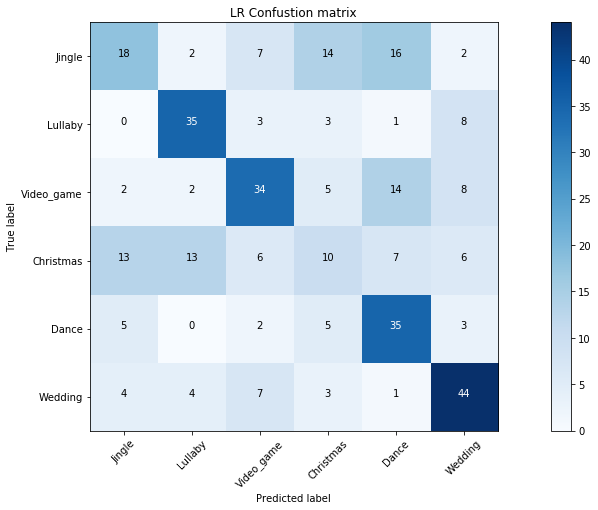

In [54]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Prediction for validation set 
pred_probs = lr_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='LR Confustion matrix')
# Save
with open('pred_probas/lr_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_LR = lr_classifier.predict_proba(x_test)
# Save
with open('pred_probas/lr_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_LR, f)

### Random Forest

Accuracy =  0.53
F-score =  0.53
ROC AUC = 0.846
Confusion matrix, without normalization
[[25  0  4 16 12  2]
 [ 2 34  1  6  1  6]
 [ 4  4 30  7 17  3]
 [11 12  2 16  6  8]
 [ 7  0  1  5 34  3]
 [ 7  5  2  4  2 43]]
CPU times: user 5.56 s, sys: 373 ms, total: 5.93 s
Wall time: 5.39 s


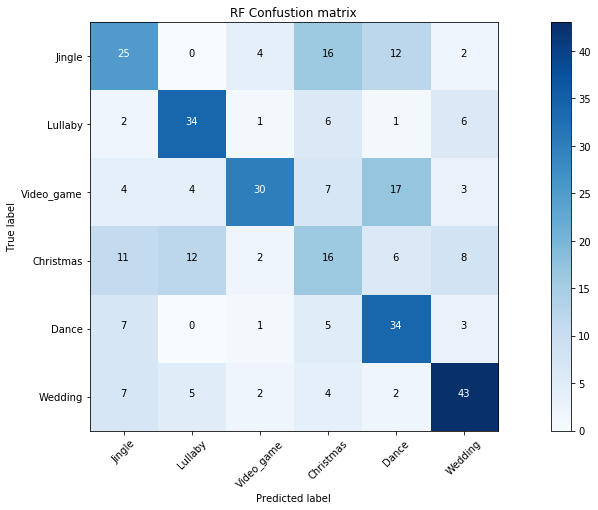

In [55]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = rf_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='RF Confustion matrix')

# Save
with open('pred_probas/rf_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
# Prediction for test set
pred_probs_RF = rf_classifier.predict_proba(x_test)
# Save
with open('pred_probas/rf_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_RF, f)

### Gradient Boosting 

Accuracy =  0.52
F-score =  0.52
ROC AUC = 0.835
Confusion matrix, without normalization
[[22  0  4 19 12  2]
 [ 1 32  2  6  1  8]
 [ 5  4 35  6 13  2]
 [15 10  3 18  3  6]
 [ 5  0  1  6 34  4]
 [ 9  6  3  8  1 36]]
CPU times: user 22.2 s, sys: 528 ms, total: 22.7 s
Wall time: 22.1 s


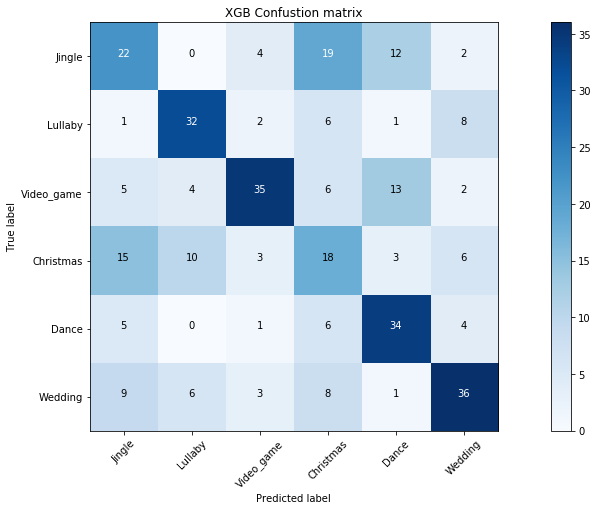

In [56]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Prediction and result (validation set)
pred_probs = xgb_classifier.predict_proba(x_val)
display_results(y_val, pred_probs, cm_title='XGB Confustion matrix')

# Save
with open('pred_probas/xgb_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_XGB = xgb_classifier.predict_proba(x_test)
# Save
with open('pred_probas/xgb_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_XGB, f)

### Support Vector Machines

Accuracy =  0.52
F-score =  0.52
ROC AUC = 0.830
Confusion matrix, without normalization
[[21  2  7 17 11  1]
 [ 0 35  3  8  0  4]
 [ 6  2 37  3 14  3]
 [12  9  4 21  3  6]
 [10  0  2  4 29  5]
 [ 5  7  6  7  2 36]]
CPU times: user 13.9 s, sys: 408 ms, total: 14.3 s
Wall time: 13.8 s


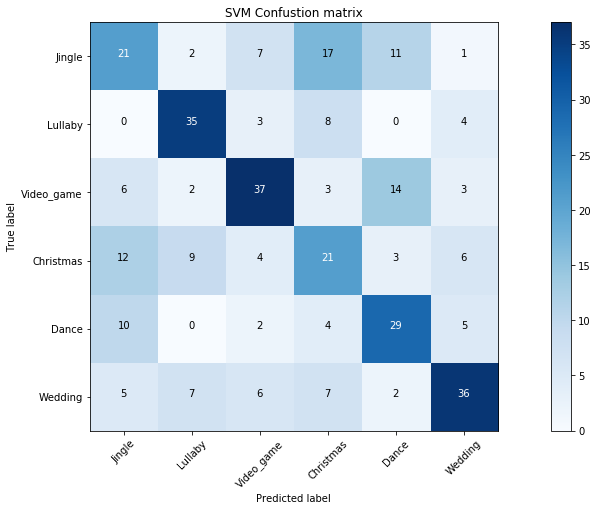

In [57]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
svm_classifier.fit(x_train, y_train)

# Predict (validation set)
pred_probs = svm_classifier.predict_proba(x_val)

# Results
display_results(y_val, pred_probs, cm_title='SVM Confustion matrix')

# Save
with open('pred_probas/svm_classifier_val.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
        
# Prediction for test set
pred_probs_SVM = svm_classifier.predict_proba(x_test)
# Save
with open('pred_probas/svm_classifier_test.pkl', 'wb') as f:
    pickle.dump(pred_probs_SVM, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

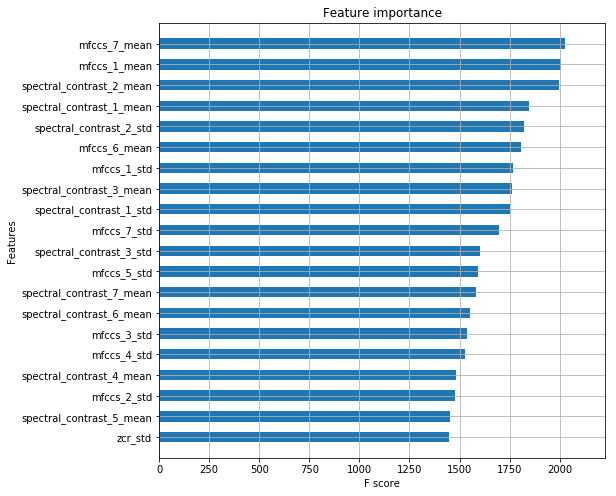

In [58]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [59]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.02079806, 0.02666937, 0.01540529, 0.02186557, 0.01533166,
       0.01413532, 0.0154605 , 0.01871825, 0.        , 0.        ,
       0.0339947 , 0.0367555 , 0.03246706, 0.02727674, 0.02674299,
       0.02856512, 0.02913568, 0.03220938, 0.03349775, 0.02946698,
       0.02611721, 0.02359567, 0.02633807, 0.02295148, 0.01527645,
       0.01985938, 0.03695796, 0.02105573, 0.0257491 , 0.02585953,
       0.02547302, 0.03324008, 0.03728926, 0.03252227, 0.02718472,
       0.02828904, 0.02808658, 0.02928293, 0.02510491, 0.03127071],
      dtype=float32)

In [60]:
top_n = [10, 20, 30, 50, 60]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_val = selection.transform(x_val)
    #select_x_train = x_train.iloc[:, :n]
    #select_x_val = x_val.iloc[:, :n]
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)
    #svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
    #svm_classifier.fit(select_x_train, y_train)
    #pred_probs = svm_classifier.predict_proba(select_x_val)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_val)

    # Results
    display_results(y_val, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Accuracy =  0.49
F-score =  0.50
ROC AUC = 0.814
()
Stats for top 20 features:
Accuracy =  0.53
F-score =  0.53
ROC AUC = 0.834
()
Stats for top 30 features:
Accuracy =  0.52
F-score =  0.52
ROC AUC = 0.841
()
Stats for top 50 features:
Accuracy =  0.52
F-score =  0.52
ROC AUC = 0.835
()
Stats for top 60 features:
Accuracy =  0.52
F-score =  0.52
ROC AUC = 0.835
()


### Ensemble of XGB and VGG

In [61]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

ValueError: operands could not be broadcast together with shapes (514,9) (514,7) 

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [8]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

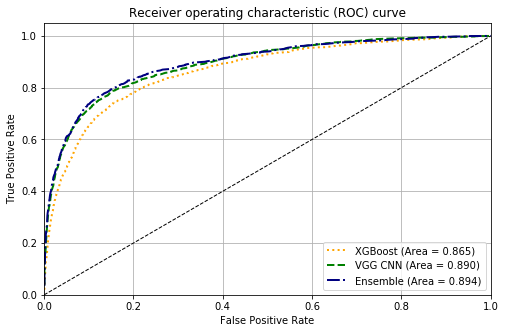

In [9]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

Test Set Accuracy =  0.40
Test Set F-score =  0.34
ROC AUC = 0.731
Confusion matrix, without normalization
[[183  60   8  16  10  34  53]
 [ 59 143  17  12   8 106  38]
 [ 24  32  56   4   2  33  20]
 [ 78  47  12  10  13  41  31]
 [ 40  35   5   5  20  13  14]
 [ 27  70  10   7   7 252  43]
 [ 48  53  12   9   8  62 137]]
CPU times: user 1min 23s, sys: 16.1 ms, total: 1min 23s
Wall time: 1min 23s


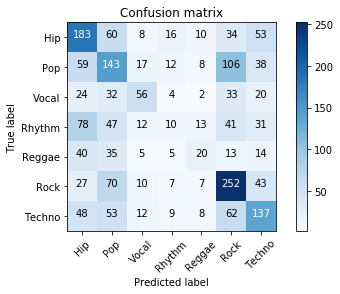

In [14]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

Test Set Accuracy =  0.57
Test Set F-score =  0.53
ROC AUC = 0.857
Confusion matrix, without normalization
[[230  55  10  14  16  14  25]
 [ 55 203  18  19   6  52  30]
 [ 12  11 106   6   4  18  14]
 [ 44  62   5  46  19  31  25]
 [ 25  32   5  14  43   8   5]
 [ 13  50   8   5   1 317  22]
 [ 23  31  11   7   3  51 203]]
CPU times: user 17min 8s, sys: 28 ms, total: 17min 8s
Wall time: 17min 8s


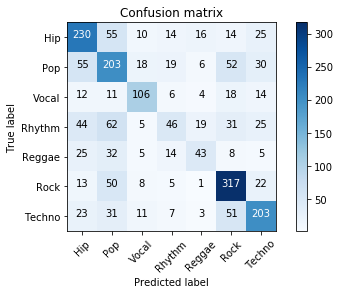

In [15]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)